In [9]:
from pybhpt.geo import KerrGeodesic
from pybhpt.radial import RadialTeukolsky
from pybhpt.teuk import TeukolskyMode
from pybhpt.hertz import HertzMode
from pybhpt.redshift import RedshiftCoefficients, Yslm
import numpy as np
import matplotlib.pyplot as plt

# Redshift Tests

## Load redshift functions

In [10]:
def u2_ecc(geo):
    a = geo.blackholespin
    rp = geo.radialpoints
    En = geo.orbitalenergy
    Lz = geo.orbitalangularmomentum
    deltaUr = np.array([np.sqrt(kerrgeo_Vr(a, En, Lz, 0., r)) for r in rp])
    u2up = pow(rp*rp - 2.*rp + a*a, -1)*(En*(rp*rp + a*a) - a*Lz - deltaUr)
    u2down = pow(rp*rp - 2.*rp + a*a, -1)*(En*(rp*rp + a*a) - a*Lz + deltaUr)
    return np.concatenate((u2up, np.flip(u2down)[1:-1]))

def u3_ecc(geo):
    a = geo.blackholespin
    r = geo.radialpoints
    En = geo.orbitalenergy
    Lz = geo.orbitalangularmomentum
    z = 0.
    I = 1.j
    Uz = 0.
    u3up = (-I)*Uz*pow(I*r + a*z,-1)*pow(2. - 2.*pow(z,2),-0.5) + (Lz + a*En*(-1. + pow(z,2)))*pow(I*r + a*z,-1)*pow(2. - 2.*pow(z,2),-0.5)
    u3down = u3up
    return np.concatenate((u3up, np.flip(u3down)[1:-1]))

def u4_ecc(geo):
    return np.conj(u3_ecc(geo))

In [21]:
from scipy.special import factorial as fac
from pybhpt.redshift import w3j
from scipy.special import sph_harm

def muCoupling(s, l):
    """
    Eigenvalue for the spin-weighted spherical harmonic lowering operator
    Setting s -> -s gives the negative of the eigenvalue for the raising operator
    """
    if l + s < 0 or l - s + 1. < 0:
        return 0
    return np.sqrt((l - s + 1.)*(l + s))

def Asjlm(s, j, l, m):
    if s >= 0:
        return (-1.)**(m + s)*np.sqrt(4**s*fac(s)**2*(2*l + 1)*(2*j + 1)/fac(2*s))*w3j(s, l, j, 0, m, -m)*w3j(s, l, j, s, -s, 0)
    else:
        return (-1.)**(m)*np.sqrt(4**(-s)*fac(-s)**2*(2*l + 1)*(2*j + 1)/fac(-2*s))*w3j(-s, l, j, 0, m, -m)*w3j(-s, l, j, s, -s, 0)

def spin_operator_normalization(s, ns, l):
    s_sgn = np.sign(s)
    nmax1 = np.abs(s) + 1
    Jterm = 1.
    for ni in range(1, ns + 1):
        Jterm *= -s_sgn*muCoupling((nmax1-ni), l)
    return Jterm

In [22]:
def full_libration(xp):
    return np.concatenate((xp, np.flip(xp[1:-1])))

def construct_hertz_radial_components(hertz, samples = 2**6):
    samples_half = int(samples/2 + 1)
    hertzR0In = np.array([hertz.radialsolution('In', i) for i in range(samples_half)])
    hertzR0Up = np.array([hertz.radialsolution('Up', i) for i in range(samples_half)])
    hertzR1In = np.array([hertz.radialderivative('In', i) for i in range(samples_half)])
    hertzR1Up = np.array([hertz.radialderivative('Up', i) for i in range(samples_half)])
    hertzR2In = np.array([hertz.radialderivative2('In', i) for i in range(samples_half)])
    hertzR2Up = np.array([hertz.radialderivative2('Up', i) for i in range(samples_half)])
    hertzR = np.array(
        [[np.concatenate((hertzR0In, np.flip(hertzR0In)[1:-1])), np.concatenate((hertzR0Up, np.flip(hertzR0Up)[1:-1]))], 
        [np.concatenate((hertzR1In, np.flip(hertzR1In)[1:-1])), np.concatenate((hertzR1Up, np.flip(hertzR1Up)[1:-1]))], 
        [np.concatenate((hertzR2In, np.flip(hertzR2In)[1:-1])), np.concatenate((hertzR2Up, np.flip(hertzR2Up)[1:-1]))]])
    return hertzR

def construct_hertz_radial_components_circ(hertz):
    i = 0
    hertzR0In = hertz.radialsolution('In', i)
    hertzR0Up = hertz.radialsolution('Up', i)
    hertzR1In = hertz.radialderivative('In', i)
    hertzR1Up = hertz.radialderivative('Up', i)
    hertzR2In = hertz.radialderivative2('In', i)
    hertzR2Up = hertz.radialderivative2('Up', i)
    hertzR = np.array(
        [[hertzR0In, hertzR0Up],
        [hertzR1In, hertzR1Up],
        [hertzR2In, hertzR2Up]]
    )
    return hertzR

def construct_hertz_polar_spin_weighting(hertz, samples = 2**6):
    samples_half = int(samples/2 + 1)
    th = np.array([hertz.polarpoint(i) for i in range(samples_half)])
    thp = full_libration(th)
    sth = np.sin(thp)
    spinWeightingPolar = np.array(
        [pow(sth, -2),
        pow(sth, -1),
        pow(sth, 0)]
    )
    return spinWeightingPolar

def redshift_mode_inc(coeffs, hertz, l, samples = 2**6):
    m = hertz.azimuthalmode
    omega = hertz.frequency
    s_sgn = np.sign(hertz.spinweight)
    huu = np.zeros((samples, 2), dtype=np.complex128)
    hertzR = construct_hertz_radial_components_circ(hertz)
    spinWeightingPolar = construct_hertz_polar_spin_weighting(hertz, samples=samples)
    for ns in range(0, 3):
        scalar_coupling = 0.
        llmin = np.max([np.abs(m), 2, l - 3 + ns])
        llmax = np.max([llmin, l + 3 - ns])
        for ll in range(llmin, llmax + 1):
            Jterm = spin_operator_normalization(s_sgn*2, ns, ll)
            scalar_coupling += Jterm*hertz.couplingcoefficient(ll)*Asjlm(s_sgn*(2-ns), l, ll, m)
        for nt in range(0, 3):
            for nph in range(0, 3):
                pref = (1.j*m)**nph*(-1.j*omega)**nt
                for nr in range(0, 3):
                    if nt + nr + ns + nph <= 2:
                        hNabcd0 = np.array([coeffs(0, nt, nr, ns, nph, 0, i) for i in range(samples)])
                        hNabcd0 *= spinWeightingPolar[ns]
                        hNabcd = np.array([hNabcd0, hNabcd0]).T
                        huuTerm = -pref*hNabcd*scalar_coupling*hertzR[nr]
                        # if np.sum(huuTerm) == 0 and np.sum(hNabcd0) != 0:
                        #     print(nt, nr, ns, nph)
                        #     print(pref, spinWeightingPolar[ns], scalar_coupling, hertzR[nr])
                        huu += huuTerm
    return huu

def redshift_mode_ecc(coeffs, hertz, l, samples = 2**6):
    m = hertz.azimuthalmode
    omega = hertz.frequency
    s_sgn = np.sign(hertz.spinweight)
    ylm = np.real(sph_harm(m, l, 0., 0.5*np.pi))
    huu = np.zeros((2, samples), dtype=np.complex128)
    if np.abs(ylm) == 0.:
        return huu
    hertzR = construct_hertz_radial_components(hertz, samples)
    for ns in range(0, 3):
        scalar_coupling = 0.
        llmin = np.max([np.abs(m), 2, l - 3 + ns])
        llmax = np.max([llmin, l + 3 - ns])
        for ll in range(llmin, llmax + 1):
            Jterm = spin_operator_normalization(s_sgn*2, ns, ll)
            scalar_coupling += Jterm*hertz.couplingcoefficient(ll)*Asjlm(s_sgn*(2-ns), l, ll, m)
        for nt in range(0, 3):
            for nph in range(0, 3):
                pref = (1.j*m)**nph*(-1.j*omega)**nt
                for nr in range(0, 3):
                    if nt + nr + ns + nph <= 2:
                        hNabcd0 = [coeffs(0, nt, nr, ns, nph, i, 0) for i in range(samples)]
                        hNabcd = np.array([hNabcd0, hNabcd0])
                        huuTerm = -pref*hNabcd*scalar_coupling*hertzR[nr]*ylm
                        huu += huuTerm
    return huu

def redshift_mode_calc(coeffs, hertz, l):
    m = hertz.azimuthalmode
    omega = hertz.frequency
    s_sgn = 1
    if np.sign(hertz.spinweight) < 0:
        s_sgn = -1
    ylm = np.real(sph_harm(m, l, 0., 0.5*np.pi))
    huu = np.array([0., 0.], dtype=np.complex128)
    if np.abs(ylm) == 0.:
        return huu
    hertzRIn = [hertz.radialsolution('In', 0), hertz.radialderivative('In', 0), hertz.radialderivative2('In', 0)]
    hertzRUp = [hertz.radialsolution('Up', 0), hertz.radialderivative('Up', 0), hertz.radialderivative2('Up', 0)]
    for ns in range(0, 3):
        scalar_coupling = 0.
        llmin = np.max([np.abs(m), 2, l - 3 + ns])
        llmax = l + 3 - ns
        for ll in range(llmin, llmax + 1):
            Jterm = spin_operator_normalization(s_sgn*2, ns, ll)
            scalar_coupling += Jterm*hertz.couplingcoefficient(ll)*Asjlm(s_sgn*(2-ns), l, ll, m)
        # print(scalar_coupling, ns, l, hertz.spheroidalmode)
        for nt in range(0, 3):
            for nph in range(0, 3):
                pref = (1.j*m)**nph*(-1.j*omega)**nt
                for nr in range(0, 3):
                    if nt + nr + ns + nph <= 2:
                        hNabcd = coeffs(0, nt, nr, ns, nph)
                        if(abs(hNabcd) > 0.):
                            huuTerm = -pref*hNabcd*scalar_coupling*np.array([hertzRIn[nr], hertzRUp[nr]])*ylm
                            # if np.abs(huuTerm[0]) + np.abs(huuTerm[1]) > 0:
                            #     print(nt, nr, ns, nph, huuTerm)
                            huu += huuTerm
    return huu

from tqdm import tqdm

def redshift_calc(gauge, lmax, geo):
    if isinstance(gauge, str):
        if gauge == "SAAB":
            return redshift_calc(["SAAB0", "SAAB4"], lmax, geo)
        elif gauge == "ASAAB":
            return redshift_calc(["ASAAB0", "ASAAB4"], lmax, geo)
        gauges = [gauge]
    else:
        gauges = gauge
    coeffs = []
    for gauge in gauges:
        coeffs.append(RedshiftCoefficients(gauge, geo))
    huuYlm = np.zeros((lmax + 1, lmax + 1, 2), dtype=np.complex128)
    s = choose_spin_from_gauge(gauges[0])
    for m in tqdm(range(0, lmax + 1)):
        jmin = np.max([2, abs(m)])
        jmax = lmax + 4 + int(20*geo.blackholespin)
        for j in range(jmin, jmax + 1):
            teuk = TeukolskyMode(s, j, m, 0, 0, geo)
            teuk.solve(geo)
            psis = []
            for i, gauge in enumerate(gauges):
                psis.append(HertzMode(teuk, gauge))
                psis[i].solve()

            for l in range(abs(m), lmax + 1):
                # huuMode = redshift_mode_calc(coeffs, hertz, l)
                # huuYlm[l, m] += huuMode
                for coeff, psi in zip(coeffs, psis):
                        huuMode = redshift_mode_calc(coeff, psi, l)
                        if np.isnan(np.sum(huuMode)):
                            print("Error ", j, l, m)
                        else:
                            huuTemp = huuMode
                            # if l == j:
                            #     print(l, m, k)
                            #     print(orbit_average_polar(huuTemp, geo, axis = 0))
                            huuYlm[l, m] += huuTemp
    
    huuYl = np.zeros((lmax + 1, 2))
    for l in range(0, lmax + 1):
        huuYl[l] += 2.*np.real(huuYlm[l, 0])
        for m in range(1, l + 1):
            huuYl[l] +=  4.*np.real(huuYlm[l, m])

    return huuYl, huuYlm

def redshift_calc_ecc(gauge, lmax, geo, nrange = [-10, 10]):
    if isinstance(gauge, str):
        if gauge == "SAAB":
            return redshift_calc_ecc(["SAAB0", "SAAB4"], lmax, geo, nrange=nrange)
        elif gauge == "ASAAB":
            return redshift_calc_ecc(["ASAAB0", "ASAAB4"], lmax, geo, nrange=nrange)
        gauges = [gauge]
    else:
        gauges = gauge
    coeffs = []
    for gauge in gauges:
        coeffs.append(RedshiftCoefficients(gauge, geo))
    samples = 2*(geo.radialpoints.shape[0] - 1)
    huuYlm = np.zeros((lmax + 1, lmax + 1, 2, samples), dtype=np.complex128)
    s = choose_spin_from_gauge(gauges[0])
    for m in tqdm(range(0, lmax + 1)):
        jmin = np.max([abs(s), abs(m)])
        jmax = lmax + 4 + int(20)
        for j in range(jmin, jmax + 1):
            nmin = nrange[0]
            nmax = nrange[1]
            for n in range(nmin, nmax + 1):
                teuk = TeukolskyMode(s, j, m, 0, n, geo)
                teuk.solve(geo)
                psis = []
                for i, gauge in enumerate(gauges):
                    psis.append(HertzMode(teuk, gauge))
                    psis[i].solve()
                phaseUp = m*geo.azimuthalradial - teuk.frequency*geo.timeradial
                phaseDown = np.flip(-phaseUp)[1:-1]
                phase = np.concatenate((phaseUp, phaseDown)) - 2.*np.pi*n*np.arange(samples)/samples
                for l in range(abs(m), lmax + 1):
                    # huuMode = redshift_mode_ecc(coeffs, hertz, l, samples=samples)
                    # # if l == j and l < 5:
                    # #     print(l, m, n, np.mean(huuMode, axis = 1))
                    # if np.isnan(np.sum(huuMode)):
                    #     print(j, l, m, n)
                    # else:
                    #     huuYlm[l, m] += huuMode*np.exp(1.j*np.array([phase, phase]))
                    for coeff, psi in zip(coeffs, psis):
                        huuMode = redshift_mode_ecc(coeff, psi, l, samples=samples)
                        if np.isnan(np.sum(huuMode)):
                            print("Error ", j, l, m, n)
                        else:
                            huuTemp = huuMode*np.exp(1.j*np.array([phase, phase]))
                            # if l == j:
                            #     print(l, m, k)
                            #     print(orbit_average_polar(huuTemp, geo, axis = 0))
                            huuYlm[l, m] += huuTemp
    
    huuYl = np.zeros((lmax + 1, 2, samples))
    for l in range(0, lmax + 1):
        huuYl[l] += 2.*np.real(huuYlm[l, 0])
        for m in range(1, l + 1):
            huuYl[l] += 4.*np.real(huuYlm[l, m])

    return huuYl, huuYlm

def choose_spin_from_gauge(gauge):
    if gauge == "ORG" or gauge == "SAAB4" or gauge == "ASAAB4":
        s = 2
    else:
        s = -2
    return s

def redshift_calc_inc(gauge, lmax, geo, krange = [-10, 10]):
    if isinstance(gauge, str):
        if gauge == "SAAB":
            return redshift_calc_inc(["SAAB0", "SAAB4"], lmax, geo, krange=krange)
        elif gauge == "ASAAB":
            return redshift_calc_inc(["ASAAB0", "ASAAB4"], lmax, geo, krange=krange)
        gauges = [gauge]
    else:
        gauges = gauge
    coeffs = []
    for gauge in gauges:
        coeffs.append(RedshiftCoefficients(gauge, geo))
    samples = 2*(geo.polarpoints.shape[0] - 1)
    huuYlm = np.zeros((lmax + 1, lmax + 1, samples, 2), dtype=np.complex128)
    Ylms = np.zeros((lmax + 1, lmax + 1, samples, 2))
    th = geo.polarpoints
    thp = full_libration(th)
    for m in range(-lmax, lmax + 1):
        for l in range(m, lmax + 1):
            ylm0 = np.array([np.real(sph_harm(m, l, 0., th)) for th in thp])
            ylm = np.array([ylm0, ylm0]).T
            Ylms[l, m] = ylm
    s = choose_spin_from_gauge(gauges[0])
    for m in tqdm(range(0, lmax + 1)):
        jmin = np.max([abs(s), abs(m)])
        jmax = lmax + 4 + int(20*geo.blackholespin)
        for j in range(jmin, jmax + 1):
            kmin = krange[0]
            kmax = krange[1]
            for k in range(kmin, kmax + 1):
                teuk = TeukolskyMode(s, j, m, k, 0, geo)
                teuk.solve(geo)
                psis = []
                for i, gauge in enumerate(gauges):
                    psis.append(HertzMode(teuk, gauge))
                    psis[i].solve()
                phaseUp = m*geo.azimuthalpolar - teuk.frequency*geo.timepolar
                phaseDown = np.flip(-phaseUp)[1:-1]
                phase = np.concatenate((phaseUp, phaseDown)) - 2.*np.pi*k*np.arange(samples)/samples
                phaseArray = np.array([phase, phase]).T
                for l in range(abs(m), lmax + 1):
                    for coeff, psi in zip(coeffs, psis):
                        huuMode = redshift_mode_inc(coeff, psi, l, samples=samples)
                        if np.isnan(np.sum(huuMode)):
                            print("Error ", j, l, m, k)
                        else:
                            huuTemp = huuMode*np.exp(1.j*phaseArray)*Ylms[l, m]
                            # if l == j:
                            #     print(l, m, k)
                            #     print(orbit_average_polar(huuTemp, geo, axis = 0))
                            huuYlm[l, m] += huuTemp
    
    huuYl = np.zeros((lmax + 1, samples, 2))
    for l in range(0, lmax + 1):
        huuYl[l] += 2.*np.real(huuYlm[l, 0])
        for m in range(1, l + 1):
            huuYl[l] += 2.*np.real(huuYlm[l, m])
            huuYl[l] += 2.*np.real(np.roll(huuYlm[l, m], int(samples/2)))

    return huuYl, huuYlm


In [23]:
from scipy.special import ellipk
from pybhpt.geo import kerrgeo_Vt_radial, kerrgeo_Vt_polar, kerrgeo_Vr, kerrgeo_Vphi_radial, kerrgeo_Vphi_polar

def huu_reg_ecc(geo):
    L = geo.orbitalangularmomentum
    r0 = np.concatenate((geo.radialpoints, np.flip(geo.radialpoints)[1:-1]))
    q = geo.blackholespin
    kappa = L**2 + q**2 + 2*q**2/r0
    k = kappa/(r0**2 + kappa)
    K = ellipk(k)
    return 4.*K/(np.pi*np.sqrt(kappa + r0**2))

def huu_reg_inc(geo):
    En = geo.orbitalenergy
    Lz = geo.orbitalangularmomentum
    Qc = geo.carterconstant
    r = geo.radialpoints[0]
    th0 = np.concatenate((geo.polarpoints, np.flip(geo.polarpoints)[1:-1]))
    q = geo.blackholespin
    return huu_reg_gen(q, En, Lz, Qc, r, th0)

def huu_reg_gen(q, En, Lz, Qc, r, th):
    sig = r**2 + q**2*np.cos(th)**2
    eta = pow(sig,-1)*pow(2.*(2.*r + sig)*pow(q,2)*(sig*(-1.*Qc + pow(Lz,2)) + (2.*r + sig*pow(En,2))*(-1.*sig + pow(r,2))) + pow(q,4)*pow(2.*r + sig,2) + pow(sig*(Qc + pow(Lz,2)) - (2.*r + sig*pow(En,2))*(-1.*sig + pow(r,2)),2),0.5)
    zeta = Qc - 1.*r*(2. + r*(-2. + pow(En,2))) + sig*pow(En,2) + pow(Lz,2) + pow(q,2) + 2.*r*(pow(q,2) + pow(r,2))*pow(sig,-1)
    k = 2*eta/(eta + zeta)
    K = ellipk(k)
    return 4.*K/(np.pi*np.sqrt(eta/k))

def completion(geo):
    dM = geo.orbitalenergy
    dJ = geo.orbitalangularmomentum
    r = geo.radialpoints[0]
    q = geo.blackholespin
    htt = 2*dM/r
    htphi = -2*dJ/r
    hphiphi = 2.*q*((r + 2.)*dJ - (r + 1)*q*dM)/r
    Omega = geo.frequencies[-1]
    ut = ut_circ(geo)
    return ut**2*(htt + 2.*Omega*htphi + Omega**2*hphiphi)

def ut_ecc(q, En, Lz, r):
    Sigma = r**2
    theta = 0.5*np.pi
    Qc = 0.
    return (np.array([kerrgeo_Vt_radial(q, En, Lz, Qc, ri) for ri in r]) + kerrgeo_Vt_polar(q, En, Lz, Qc, theta))/Sigma

def uphi_ecc(q, En, Lz, r):
    Sigma = r**2
    theta = 0.5*np.pi
    Qc = 0.
    return (np.array([kerrgeo_Vphi_radial(q, En, Lz, Qc, ri) for ri in r]) + kerrgeo_Vphi_polar(q, En, Lz, Qc, theta))/Sigma

def ur_ecc(q, En, Lz, r):
    r0 = np.unique(r)
    Sigma = r**2
    Qc = 0.
    urUp = np.sqrt(np.abs(np.array([kerrgeo_Vr(q, En, Lz, Qc, ri) for ri in r0])))
    urUp[0] = 0.
    urUp[-1] = 0.
    urDown = -np.flip(urUp)[1:-1]
    ur = np.concatenate((urUp, urDown))/Sigma
    return ur

def ut_ecc_geo(geo):
    dM = geo.orbitalenergy
    dJ = geo.orbitalangularmomentum
    r = np.concatenate((geo.radialpoints, np.flip(geo.radialpoints)[1:-1]))
    q = geo.blackholespin
    return ut_ecc(q, dM, dJ, r)

def ur_ecc_geo(geo):
    dM = geo.orbitalenergy
    dJ = geo.orbitalangularmomentum
    r = np.concatenate((geo.radialpoints, np.flip(geo.radialpoints)[1:-1]))
    q = geo.blackholespin
    return ur_ecc(q, dM, dJ, r)

def uphi_ecc_geo(geo):
    dM = geo.orbitalenergy
    dJ = geo.orbitalangularmomentum
    r = np.concatenate((geo.radialpoints, np.flip(geo.radialpoints)[1:-1]))
    q = geo.blackholespin
    return uphi_ecc(q, dM, dJ, r)

def completion_ecc(geo):
    dM = geo.orbitalenergy
    dJ = geo.orbitalangularmomentum
    r = np.concatenate((geo.radialpoints, np.flip(geo.radialpoints)[1:-1]))
    q = geo.blackholespin
    htt = 2*dM/r
    hrr = 2.*r**2*((r + q**2)*dM - q*dJ)/(r**2 - 2.*r + q**2)**2
    htphi = -2*dJ/r
    hphiphi = 2.*q*((r + 2.)*dJ - (r + 1)*q*dM)/r
    ut = ut_ecc(q, dM, dJ, r)
    uphi = uphi_ecc(q, dM, dJ, r)
    ur = ur_ecc(q, dM, dJ, r)
    # return np.mean(r**2*(htt*ut*ut + 2*htphi*ut*uphi + hrr*ur*ur + hphiphi*uphi*uphi))/np.mean(r**2)
    return (htt*ut*ut + 2*htphi*ut*uphi + hrr*ur*ur + hphiphi*uphi*uphi)

def orbit_average_ecc(func, geo, axis = 0):
    r = np.concatenate((geo.radialpoints, np.flip(geo.radialpoints)[1:-1]))
    return np.mean(func*r**2, axis = axis)/np.mean(r**2)

def orbit_average_inc(func, geo, axis = 0):
    th = np.concatenate((geo.polarpoints, np.flip(geo.polarpoints)[1:-1])).T
    r = geo.radialpoints[0]
    q = geo.blackholespin
    sig = r**2 + q**2*np.cos(th)**2
    if len(func.shape) <= 1:
        sigA = np.array(sig)
    else:
        sigA = np.array([sig, sig]).T
    return np.mean(func*sigA, axis = axis)/np.mean(sig)

In [24]:
# def Tr_ecc_geo(geo):
#     dM = geo.orbitalenergy
#     dJ = geo.orbitalangularmomentum
#     r = np.concatenate((geo.radialpoints, np.flip(geo.radialpoints)[1:-1]))
#     q = geo.blackholespin
#     return 2.*np.pi/geoEcc.minofrequencies[1]*np.mean(ut_ecc(q, dM, dJ, r)*r**2)
    
# def TTr_ecc_geo(geo):
#     dM = geo.orbitalenergy
#     dJ = geo.orbitalangularmomentum
#     r = np.concatenate((geo.radialpoints, np.flip(geo.radialpoints)[1:-1]))
#     q = geo.blackholespin
#     return 2.*np.pi/geoEcc.minofrequencies[1]*np.mean(r**2)

def Tr_ecc_geo_ratio(geo):
    dM = geo.orbitalenergy
    dJ = geo.orbitalangularmomentum
    r = np.concatenate((geo.radialpoints, np.flip(geo.radialpoints)[1:-1]))
    q = geo.blackholespin
    return np.mean(ut_ecc(q, dM, dJ, r)*r**2)/np.mean(r**2)

## Circ Test

In [152]:
geoCirc = KerrGeodesic(0.9, 4., 0., 1.0, 2**2)
lmax = 30
huuCirc = redshift_calc('IRG', lmax, geoCirc)

100%|██████████| 31/31 [02:51<00:00,  5.54s/it]


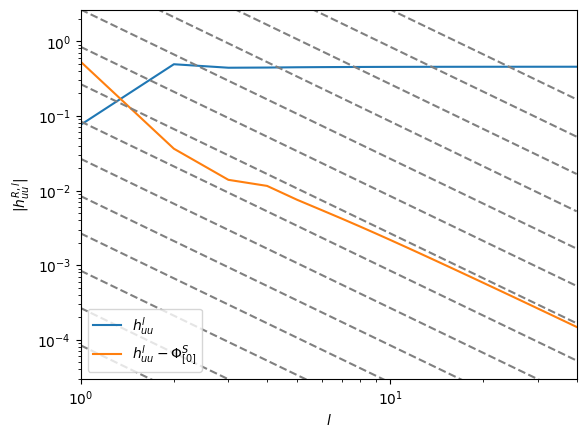

In [136]:
lmodes = np.arange(1., lmax+1)
huuregB = orbit_average(huu_reg(geoCirc), geoCirc)
huul = huuCirc[0][:lmax+1]
data = huul
datareg = huul - huuregB
ymin = np.min(np.abs(datareg[1:]))/5
ymax = 5*np.max(np.abs(datareg[1:]))
plt.loglog(lmodes, np.abs(data[1:, 1]), label = '$h_{uu}^l$')
plt.loglog(lmodes, np.abs(datareg[1:, 1]), label = '$h_{uu}^l - \Phi^S_{[0]}$')
for i in range(20):
    plt.loglog(lmodes, ymax*10.**(2-0.5*i)*lmodes**(-2), '--', color='gray')
plt.ylim(ymin, ymax)
plt.xlim(1, lmax)
plt.xlabel("$l$")
plt.ylabel("$|h_{uu}^{R,l}|$")
plt.legend()
plt.show()

In [137]:
from scipy.optimize import lsq_linear
def lbasis(lmax):
    return [1., ((lmax + 1)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)/(2*lmax - 1)/(2*lmax + 5))]

# def lbasis(lmax):
#     return [1., ((lmax + 1)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3))]

# def lbasis(lmax):
#     return [1., ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)/(2*lmax - 1)/(2*lmax + 5))]

lminTest = 20
lmaxTest = lmax
ysum = np.array([np.sum(huul[:lmax + 1, 1]) for lmax in range(lminTest, lmaxTest + 1)])
xsum = np.array([lbasis(lmax) for lmax in range(lminTest, lmaxTest + 1)])

b = lsq_linear(xsum, ysum)
print(b)

 active_mask: array([0., 0., 0., 0.])
        cost: 2.0820760659797022e-19
         fun: array([ 3.05977466e-10, -2.11958451e-10, -2.68915556e-10, -1.59310787e-10,
       -2.14939178e-11,  8.67590444e-11,  1.48098422e-10,  1.64337877e-10,
        1.45204737e-10,  1.02774678e-10,  4.85691487e-11, -7.49800222e-12,
       -5.75361980e-11, -9.56461577e-11, -1.17678312e-10, -1.20971677e-10,
       -1.04009246e-10, -6.63078481e-11, -7.97939492e-12,  7.02762293e-11,
        1.67396763e-10])
     message: 'The unconstrained solution is optimal.'
         nit: 0
  optimality: 3.0091484859440243e-12
      status: 3
     success: True
           x: array([-1.01352567,  0.45592775,  0.97562822, -3.28731557])


In [82]:
geoCirc = KerrGeodesic(0., 10., 0., 1.0, 2**2)
lmax = 25
huuCirc = redshift_calc('SAAB', lmax, geoCirc)

100%|██████████| 26/26 [00:20<00:00,  1.29it/s]


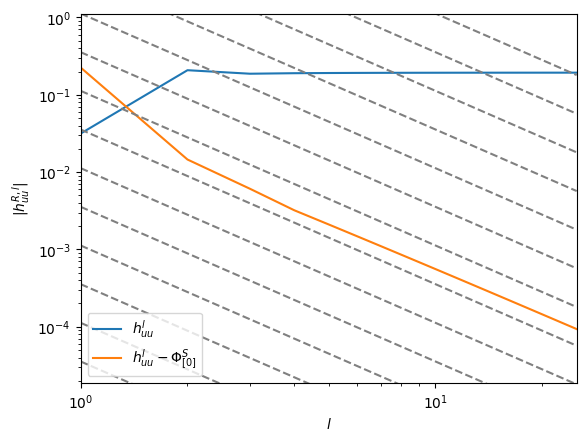

In [93]:
lmodes = np.arange(1., lmax+1)
huuregB = orbit_average(huu_reg(geoCirc), geoCirc)
huul = 4*huuCirc[0][:lmax+1]
data = huul
datareg = huul - huuregB
ymin = np.min(np.abs(datareg[1:]))/5
ymax = 5*np.max(np.abs(datareg[1:]))
plt.loglog(lmodes, np.abs(data[1:, 1]), label = '$h_{uu}^l$')
plt.loglog(lmodes, np.abs(datareg[1:, 1]), label = '$h_{uu}^l - \Phi^S_{[0]}$')
for i in range(20):
    plt.loglog(lmodes, ymax*10.**(2-0.5*i)*lmodes**(-2), '--', color='gray')
plt.ylim(ymin, ymax)
plt.xlim(1, lmax)
plt.xlabel("$l$")
plt.ylabel("$|h_{uu}^{R,l}|$")
plt.legend()
plt.show()

In [150]:
def lbasis(lmax):
    return [1., ((lmax + 1)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)/(2*lmax - 1)/(2*lmax + 5))]

# def lbasis(lmax):
#     return [1., ((lmax + 1)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3))]

# def lbasis(lmax):
#     return [1., ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)/(2*lmax - 1)/(2*lmax + 5))]

lminTest = 20
lmaxTest = lmax
ysum = np.array([np.sum(huul[:lmax + 1, 1]) for lmax in range(lminTest, lmaxTest + 1)])
xsum = np.array([lbasis(lmax) for lmax in range(lminTest, lmaxTest + 1)])

b = lsq_linear(xsum, ysum)
print(b)

 active_mask: array([0., 0., 0., 0.])
        cost: 2.0820760659797022e-19
         fun: array([ 3.05977466e-10, -2.11958451e-10, -2.68915556e-10, -1.59310787e-10,
       -2.14939178e-11,  8.67590444e-11,  1.48098422e-10,  1.64337877e-10,
        1.45204737e-10,  1.02774678e-10,  4.85691487e-11, -7.49800222e-12,
       -5.75361980e-11, -9.56461577e-11, -1.17678312e-10, -1.20971677e-10,
       -1.04009246e-10, -6.63078481e-11, -7.97939492e-12,  7.02762293e-11,
        1.67396763e-10])
     message: 'The unconstrained solution is optimal.'
         nit: 0
  optimality: 3.0091484859440243e-12
      status: 3
     success: True
           x: array([-1.01352567,  0.45592775,  0.97562822, -3.28731557])


In [151]:
print(b.x[1] - huuregB)
hcomp =  completion(geoCirc)
zval = 0.5*(b.x[0] + hcomp)*Tr_ecc_geo_ratio(geoCirc)
if geoCirc.blackholespin == 0.:
    mval = -0.12912227
else:
    mval = -0.1201650349
zval, 1-zval/mval

-3.653166102957073e-10


(-0.32570442933089516, -1.7104758851186852)

## Eccentric Test

In [25]:
geoEcc = KerrGeodesic(0.5, 10., 0.1, 1.0, 2**6)
huuData0 = redshift_calc_ecc('IRG', 30, geoEcc, nrange = [-15, 15])

  6%|▋         | 2/31 [12:15<2:57:38, 367.52s/it]


KeyboardInterrupt: 

In [141]:
huuData0 = np.load("munnaData/redshift_a50_p20_e40.npy")
# huuData1 = np.load("munnaData/redshift_a25_p20_e40_plus.npy")
huuData2 = np.load("munnaData/redshift_a50_p20_e40_minus.npy")

In [143]:
from scipy.optimize import lsq_linear
def lbasis(lmax):
    return [1., ((lmax + 1)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)/(2*lmax - 1)/(2*lmax + 5))]

def lfit(huul, lminTest, lmaxTest):
    ysum = np.array([np.sum(huul[:lmax + 1, 1]) for lmax in range(lminTest, lmaxTest + 1)])
    xsum = np.array([lbasis(lmax) for lmax in range(lminTest, lmaxTest + 1)])
    b = lsq_linear(xsum, ysum)
    return b.x[0], b.x[1]

def redshift_fit_plot(a, p, e, samples, huuData = None):
    geoEcc = KerrGeodesic(a, p, e, 1.0, samples)
    if huuData is None:
        fn = "munnaData/redshift_a{}_p{}_e{}.npy".format(int(100*a), int(p), int(100*e))
        huuData = np.load(fn)
    huul = orbit_average_ecc(huuData, geoEcc, axis = 2)
    huuregB = orbit_average_ecc(huu_reg_ecc(geoEcc), geoEcc)
    datareg = huul - huuregB
    lmax = huul.shape[0] - 1
    ymin = np.min(np.abs(datareg[1:lmax + 1]))/5
    ymax = 5*np.max(np.abs(datareg[1:lmax +1]))
    plt.loglog(lmodes, np.abs(datareg[1:lmax + 1]))
    for i in range(20):
        plt.loglog(lmodes, ymax*10.**(2-0.5*i)*lmodes**(-2), '--', color='gray')
    plt.ylim(ymin, ymax)
    plt.xlim(1, lmax)
    plt.xlabel("$l$")
    plt.ylabel("$|h_{uu}^l - B_0|$")
    plt.show()

def redshift_fit_recon(a, p, e, samples):
    geoEcc = KerrGeodesic(a, p, e, 1.0, samples)
    fn = "munnaData/redshift_a{}_p{}_e{}.npy".format(int(100*a), int(p), int(100*e))
    huuData = np.load(fn)
    huul = orbit_average_ecc(huuData, geoEcc, axis = 2)
    huuregB = orbit_average_ecc(huu_reg_ecc(geoEcc), geoEcc)
    huuTest = []
    huuRegTest = []
    for lmin in range(10, 15):
        for lmax in range(25, 30):
            b = lfit(huul, lmin, lmax)
            huuTest.append(b[0])
            huuRegTest.append(b[1])

    huus = np.sort(np.array(huuTest))[2:-2]
    return np.mean(huus), np.sqrt(np.cov(huus)), np.mean(huuRegTest) - huuregB

def redshift_fit(a, p, e, samples):
    geoEcc = KerrGeodesic(a, p, e, 1.0, samples)
    huuData = redshift_fit_recon(a, p, e, samples)
    hcomp =  orbit_average_ecc(completion_ecc(geoEcc), geoEcc)
    zval = 0.5*(huuData[0] + hcomp)*Tr_ecc_geo_ratio(geoEcc)
    zerr = 0.5*(huuData[1])*Tr_ecc_geo_ratio(geoEcc)
    return zval, zerr, huuData[2]

In [153]:
geoTest = KerrGeodesic(0.25, 20., 0.4, 1., 2**9)

In [155]:
orbit_average_ecc(huuData0, geoTest, axis=2)

array([[ 0.00057812,  0.00049952],
       [-0.00378389, -0.00378194],
       [ 0.08431669,  0.08439596],
       [ 0.08234628,  0.08234462],
       [ 0.08275232,  0.08275179],
       [ 0.08292733,  0.0829271 ],
       [ 0.08302328,  0.08302319],
       [ 0.08308179,  0.08308175],
       [ 0.08312018,  0.08312016],
       [ 0.08314677,  0.08314675],
       [ 0.08316595,  0.08316594],
       [ 0.08318026,  0.08318025],
       [ 0.0831912 ,  0.0831912 ],
       [ 0.08319974,  0.08319974],
       [ 0.08320638,  0.08320638],
       [ 0.08321116,  0.08321117],
       [ 0.08321314,  0.08321316],
       [ 0.08320921,  0.08320927],
       [ 0.08319173,  0.08319187],
       [ 0.08314496,  0.08314529],
       [ 0.08304127,  0.08304192],
       [ 0.0828401 ,  0.08284125],
       [ 0.08249458,  0.0824964 ],
       [ 0.08196934,  0.08197189],
       [ 0.08126654,  0.08126967],
       [ 0.08044669,  0.08045005],
       [ 0.07962311,  0.07962618],
       [ 0.07891762,  0.07891997],
       [ 0.0783927 ,

In [133]:
avals = [0.25, 0.5, 0.9]
pvals = [10., 20.]
evals = [0.1]
huuDataMunna = []
for a in avals:
    for p in pvals:
        for e in evals:
            huu, huuerror, _ = redshift_fit(a, p, e, 2**7)
            huuDataMunna.append([a,p,e,huu,huuerror])

In [135]:
np.savetxt('munnaData/redshift_vals.txt', np.array(huuDataMunna), header="a, p, e, huu, huu_error")

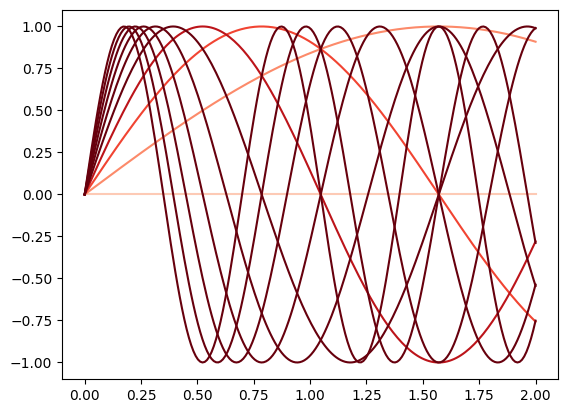

In [100]:
import matplotlib as mpl
n = 10
colors = mpl.colormaps["Reds"](np.linspace(0, 2, n+1)[1:])
for i in range(n):
    plt.plot(np.linspace(0, 2, 200), np.sin(i*np.linspace(0, 2, 200)), color=colors[i])
plt.show()

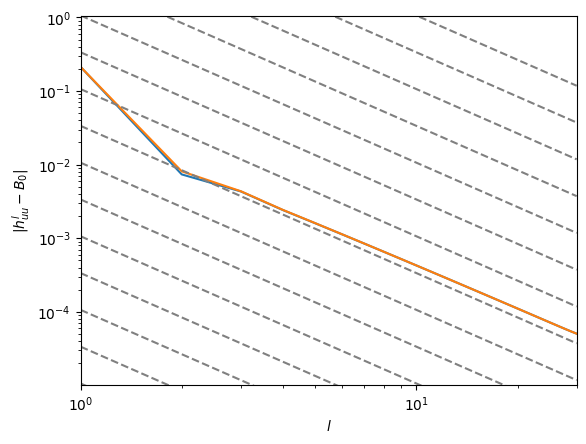

In [52]:
huuDataTest = huuData0
lmax = huuDataTest.shape[0] - 1
lmodes = np.arange(1., lmax+1)
huuregB = orbit_average_ecc(huu_reg_ecc(geoEcc), geoEcc)
huul = orbit_average_ecc(huuDataTest, geoEcc, axis = 2)
datareg = huul - huuregB
ymin = np.min(np.abs(datareg[1:lmax + 1]))/5
ymax = 5*np.max(np.abs(datareg[1:lmax +1]))
plt.loglog(lmodes, np.abs(datareg[1:lmax + 1]))
for i in range(20):
    plt.loglog(lmodes, ymax*10.**(2-0.5*i)*lmodes**(-2), '--', color='gray')
plt.ylim(ymin, ymax)
plt.xlim(1, lmax)
plt.xlabel("$l$")
plt.ylabel("$|h_{uu}^l - B_0|$")
plt.show()

In [56]:

print(b)

 active_mask: array([0., 0., 0., 0.])
        cost: 1.70455665808106e-13
         fun: array([ 9.96452632e-08, -5.83814819e-08, -9.82856325e-08, -8.12716650e-08,
       -4.06210066e-08,  5.30596944e-09,  4.64081800e-08,  7.72770430e-08,
        9.52217025e-08,  9.91531892e-08,  8.89593705e-08,  6.51904202e-08,
        2.89862534e-08, -1.77370465e-08, -7.17344202e-08, -1.27285412e-07,
       -1.74051757e-07, -1.93278033e-07, -1.51297982e-07,  1.12201572e-08,
        3.96576911e-07])
     message: 'The unconstrained solution is optimal.'
         nit: 0
  optimality: 5.853095785823825e-13
      status: 3
     success: True
           x: array([-0.40968653,  0.1920709 ,  0.18512987,  0.16585631])


In [57]:
1-b.x[1]/huuregB

1.2813193576155513e-06

In [58]:
hcomp =  orbit_average_ecc(completion_ecc(geoEcc), geoEcc)
zval = 0.5*(b.x[0] + hcomp)*Tr_ecc_geo_ratio(geoEcc)
zval

-0.11877442425297294

In [292]:
# zvalComp = -0.0892184417213
# zval - zvalComp

## Inclined Test

In [157]:
geoInc = KerrGeodesic(0.5, 10., 0., 0.9, 2**7)
lmax = 30
huuDataIRG = redshift_calc_inc('IRG', lmax, geoInc, krange = [-15, 15])
# huuDataORG = redshift_calc_inc('ORG', 25, geoInc, krange = [-12, 12])

100%|██████████| 31/31 [1:45:22<00:00, 203.96s/it]  


In [171]:
huuDataIRGKPlus = redshift_calc_inc('IRG', lmax, geoInc, krange = [16, 20])
huuDataIRGKMinus = redshift_calc_inc('IRG', lmax, geoInc, krange = [-20, -16])

100%|██████████| 31/31 [10:58<00:00, 21.23s/it]


In [178]:
huuDataIRGKPlus2 = redshift_calc_inc('IRG', lmax, geoInc, krange = [21, 25])
huuDataIRGKMinus2 = redshift_calc_inc('IRG', lmax, geoInc, krange = [-25, -21])

100%|██████████| 31/31 [10:23<00:00, 20.11s/it]


In [158]:
# geoInc = KerrGeodesic(0.5, 10., 0., 0.9, 2**6)
# huuDataIRG2 = redshift_calc_inc('IRG', 10, geoInc, krange = [-8, 8])

In [172]:
huuDataIRGAdd = (huuDataIRG[0] + huuDataIRGKPlus[0] + huuDataIRGKMinus[0], huuDataIRG[1] + huuDataIRGKPlus[1] + huuDataIRGKMinus[1])

In [179]:
orbit_average_inc(huuDataIRGKPlus2[0][:lmaxTemp+1], geoInc, axis = 1) + orbit_average_inc(huuDataIRGKMinus2[0][:lmaxTemp+1], geoInc, axis = 1)

array([[-2.56985339e-24, -6.21271877e-25],
       [ 5.11158931e-23,  5.25259012e-23],
       [ 7.69012604e-22,  1.02701513e-21],
       [ 3.78184504e-20,  5.36415029e-20],
       [ 1.96930739e-20,  9.27873621e-20],
       [ 1.08963543e-18,  1.09508903e-18],
       [-1.10928193e-18, -9.99261543e-19],
       [ 3.66376281e-18,  4.30298534e-18],
       [ 3.41953016e-18,  3.65847143e-18],
       [-4.92119496e-18, -7.09782563e-18],
       [-5.41965329e-19, -1.92940941e-18],
       [-4.85607544e-19,  3.72443352e-18],
       [-7.28410687e-19,  1.06009813e-18],
       [ 6.73347593e-18,  5.80128401e-18],
       [-2.31500819e-19,  1.40852347e-18],
       [-5.76593123e-18, -7.76440565e-18],
       [-3.32738212e-19, -1.36109401e-20],
       [ 3.48762824e-19,  1.11241752e-19],
       [ 3.97636704e-17,  3.27012403e-17],
       [ 4.66652109e-16,  4.82072409e-16],
       [ 3.87366259e-15,  3.90315868e-15],
       [ 2.86138896e-14,  2.87914611e-14],
       [ 1.85834133e-13,  1.86800860e-13],
       [ 1.

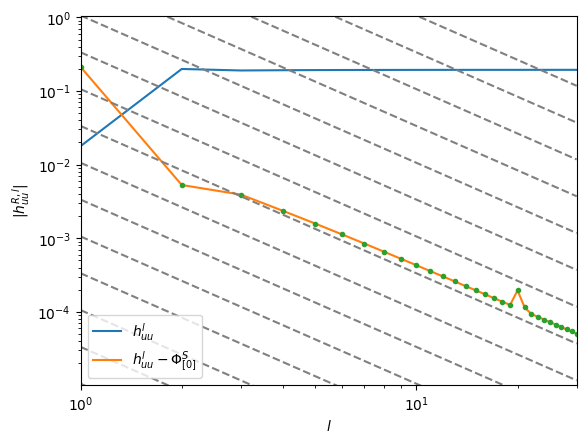

In [173]:
# plt.plot(np.abs(np.mean(huuData[0][1:], axis=2)))
# lmax = huuDataORG[0].shape[0] - 2
lmaxTemp = lmax
lmodes = np.arange(1., lmaxTemp+1)
huuregB = orbit_average_inc(huu_reg_inc(geoInc), geoInc)
huul = orbit_average_inc(huuDataIRGAdd[0][:lmaxTemp+1], geoInc, axis = 1)
data = huul
datareg = huul - huuregB
ymin = np.min(np.abs(datareg[1:]))/5
ymax = 5*np.max(np.abs(datareg[1:]))
plt.loglog(lmodes, np.abs(data[1:, 1]), label = '$h_{uu}^l$')
plt.loglog(lmodes, np.abs(datareg[1:, 1]), label = '$h_{uu}^l - \Phi^S_{[0]}$')
plt.loglog(lmodes, np.abs(datareg[1:, 1]), '.')
for i in range(20):
    plt.loglog(lmodes, ymax*10.**(2-0.5*i)*lmodes**(-2), '--', color='gray')
plt.ylim(ymin, ymax)
plt.xlim(1, lmaxTemp)
plt.xlabel("$l$")
plt.ylabel("$|h_{uu}^{R,l}|$")
plt.legend()
plt.show()

In [180]:
from scipy.optimize import lsq_linear
def lbasis(lmax):
    return [1., ((lmax + 1)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)/(2*lmax - 1)/(2*lmax + 5))]

# def lbasis(lmax):
#     return [1., ((lmax + 1)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3))]

# def lbasis(lmax):
#     return [1., ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)/(2*lmax - 1)/(2*lmax + 5))]

lminTest = 5
lmaxTest = lmax
ysum = np.array([np.sum(huul[:lmax + 1, 1]) for lmax in range(lminTest, lmaxTest + 1)])
xsum = np.array([lbasis(lmax) for lmax in range(lminTest, lmaxTest + 1)])

b = lsq_linear(xsum, ysum)
print(b)

 active_mask: array([0., 0., 0., 0.])
        cost: 5.71325344838128e-09
         fun: array([-4.05916267e-06,  3.22710938e-07,  4.83264502e-06,  6.50609695e-06,
        6.71239638e-06,  5.84186181e-06,  3.14294890e-06, -1.17629940e-07,
       -4.12969989e-06, -9.15688151e-06, -1.43401996e-05, -2.01092034e-05,
       -2.64205555e-05, -3.27557733e-05, -3.93965609e-05,  3.73125940e-05,
        4.29190392e-05,  3.58457032e-05,  2.85451602e-05,  2.09375492e-05,
        1.30224656e-05,  5.12430101e-06, -2.86150392e-06, -1.10642698e-05,
       -1.92025143e-05, -2.74515176e-05])
     message: 'The unconstrained solution is optimal.'
         nit: 0
  optimality: 1.6044943151882762e-12
      status: 3
     success: True
           x: array([-0.41392927,  0.19378405,  0.18456836, -0.02270416])


In [181]:
b.x[1] - huuregB

-9.341994621409055e-06

In [182]:
lmax = huuDataIRG[0].shape[0] - 1
lmodes = np.arange(1., lmax+1)
huuregB = b.x[1]
huul = orbit_average_polar(huuDataIRG[0], geoInc, axis = 1)
datareg = huul - huuregB
ymin = np.min(np.abs(datareg[1:]))/5
ymax = 5*np.max(np.abs(datareg[1:]))
plt.loglog(lmodes, np.abs(datareg[1:]))
for i in range(20):
    plt.loglog(lmodes, ymax*10.**(2-0.5*i)*lmodes**(-2), '--', color='gray')
plt.ylim(ymin, ymax)
plt.xlim(1, lmax)
plt.xlabel("$l$")
plt.ylabel("$|h_{uu}^l - B_0|$")
plt.show()

NameError: name 'orbit_average_polar' is not defined

In [366]:
# from pybhpt.geo import KerrGeodesic
# from pybhpt.redshift import circular_redshift_export
# geoCirc = KerrGeodesic(0., 10., 0.0, 1.0, 2**2)
# circular_redshift_export("test.txt", "ORG", 2, geoCirc)

In [22]:
geo = KerrGeodesic(0., 6., 0., 1.0, 2**2)
m = 2
teuk = TeukolskyMode(-2, m, m, 0, 0, geo)
teuk.solve(geo)
print(teuk.amplitude('Up'),
      teuk.amplitude('Up')/geo.mode_frequency(m, 0, 0)**2, 
      geo.mode_frequency(m, 0, 0)**2)

(0.008763336582675862-0.002949020148629884j) (0.47322017546449613-0.1592470880260136j) 0.018518518518518535


In [23]:
geo = KerrGeodesic(0.25, 6., 0., 1.0, 2**2)
m = 2
teuk = TeukolskyMode(-2, m, m, 0, 0, geo)
teuk.solve(geo)
print(teuk.amplitude('Up'),
      teuk.amplitude('Up')/geo.mode_frequency(m, 0, 0)**2, 
      geo.mode_frequency(m, 0, 0)**2)

(0.007982096601320758-0.0027202774414030856j) (0.44582198454384575-0.15193495493846934j) 0.017904223833842214


In [24]:
geo = KerrGeodesic(0., 7., 0., 1.0, 2**2)
m = 2
lmodes = np.arange(m, 16)
jmodes = np.arange(m, 40)
Zs = np.zeros(lmodes.shape[0], dtype=np.complex128)
for j in jmodes:
    teuk = TeukolskyMode(-2, j, m, 0, 0, geo)
    teuk.solve(geo)
    for l in lmodes:
        Z = teuk.couplingcoefficient(l)*teuk.amplitude('Up')
        Zs[l-m] += Z

In [25]:
comparison=np.array([7.96233358e-01-2.64339239e-01j, 3.26116438e-02-1.78284989e-02j,
       3.01992796e-03-1.94391386e-03j, 1.08462121e-04-7.90232072e-05j,
       7.07885016e-06-5.62397831e-06j, 2.01742927e-07-1.72430029e-07j,
       1.01260565e-08-9.18856175e-09j, 2.35628290e-10-2.25437583e-10j,
       9.59773545e-12-9.61726001e-12j, 1.87893538e-13-1.96359571e-13j,
       6.43702345e-15-6.98757969e-15j, 1.08572641e-16-1.22077267e-16j,
       3.20890107e-18-3.72706056e-18j, 4.75046181e-20-5.68798318e-20j])

In [26]:
amps=2.*Zs/geo.mode_frequency(m, 0, 0)**2
amps

array([7.96233350e-01-2.64339220e-01j, 3.26116422e-02-1.78284971e-02j,
       3.01992799e-03-1.94391369e-03j, 1.08462123e-04-7.90232012e-05j,
       7.07885019e-06-5.62397786e-06j, 2.01742910e-07-1.72430002e-07j,
       1.01260550e-08-9.18855955e-09j, 2.35628258e-10-2.25437525e-10j,
       9.59773216e-12-9.61725596e-12j, 1.87893436e-13-1.96359453e-13j,
       6.43701920e-15-6.98757466e-15j, 1.08572549e-16-1.22077157e-16j,
       3.20889780e-18-3.72705656e-18j, 4.75045635e-20-5.68797632e-20j])

## Generic

In [18]:
class ModeSummer:
    def __init__(self, shape, dtype=np.float64, error_compare = None, rtol = 1.e-14, atol = 1.e-12):
        self.sum = np.zeros(shape, dtype=dtype)
        self.prior = np.zeros(shape, dtype=dtype) + 1.e-20
        self.max_value = np.abs(self.sum)
        self.rel_error = np.ones(shape)
        self.abs_error = np.ones(shape)
        self.error_compare = error_compare
        self.rtol = rtol
        self.atol = atol
        self.passes = 0
        self.precision_loss = np.ones(shape)
        self.eps = np.abs(np.finfo(dtype).eps)
    
    def add(self, term):
        self.prior = self.sum.copy()
        self.prior[np.abs(self.prior) == 0.] = 1.e-20
        self.sum += term
        self.track_precision(term)

        if self.error_compare is None:
            sum_compare = self.prior
        else:
            sum_compare = self.error_compare
        
        self.rel_error = np.abs(1. - self.sum/sum_compare)
        self.abs_error = np.abs(self.sum - self.prior)

    def track_precision(self, term):
        absTerm = np.abs(term)
        self.max_value = np.maximum(self.max_value, absTerm)
        absSum = np.abs(self.sum)
        nonzeros = (absSum > 0)
        zeros = np.invert(nonzeros)
        loss_check = absTerm.copy()
        loss_check[nonzeros] = (np.abs(self.prior[nonzeros]) + absTerm[nonzeros])/absSum[nonzeros]
        loss_check[zeros] = np.log10(absTerm[zeros])
        prec_loss = (loss_check >= 1.)
        prec_gain = np.invert(prec_loss)
        nonzero_gain = np.minimum(prec_gain, nonzeros)
        

        self.precision_loss[prec_loss] *= loss_check[prec_loss]
        self.precision_loss[nonzero_gain] *= np.abs(self.prior[nonzero_gain]/absTerm[nonzero_gain])
        self.precision_loss[self.precision_loss < 1.] = 1.
        self.precision_loss

    def error_test(self):
        rel_error_check = self.rel_error < (self.rtol*self.precision_loss)
        abs_error_check = self.abs_error < self.atol
        tot_error_check = np.maximum(rel_error_check, abs_error_check)
        
        if np.all(tot_error_check):
            self.passes += 1

    @property
    def precisions(self):
        return self.precision_loss*self.eps
        

In [110]:
def construct_hertz_radial_components(hertz, samples = 2**6):
    samples_half = int(samples/2 + 1)
    hertzR0In = np.array([hertz.radialsolution('In', i) for i in range(samples_half)])
    hertzR0Up = np.array([hertz.radialsolution('Up', i) for i in range(samples_half)])
    hertzR1In = np.array([hertz.radialderivative('In', i) for i in range(samples_half)])
    hertzR1Up = np.array([hertz.radialderivative('Up', i) for i in range(samples_half)])
    hertzR2In = np.array([hertz.radialderivative2('In', i) for i in range(samples_half)])
    hertzR2Up = np.array([hertz.radialderivative2('Up', i) for i in range(samples_half)])
    hertzR = np.array(
        [[np.concatenate((hertzR0In, np.flip(hertzR0In)[1:-1])), np.concatenate((hertzR0Up, np.flip(hertzR0Up)[1:-1]))], 
        [np.concatenate((hertzR1In, np.flip(hertzR1In)[1:-1])), np.concatenate((hertzR1Up, np.flip(hertzR1Up)[1:-1]))], 
        [np.concatenate((hertzR2In, np.flip(hertzR2In)[1:-1])), np.concatenate((hertzR2Up, np.flip(hertzR2Up)[1:-1]))]])
    return hertzR


def construct_hertz_polar_spin_weighting(hertz, samples = 2**6):
    samples_half = int(samples/2 + 1)
    th = np.array([hertz.polarpoint(i) for i in range(samples_half)])
    thp = full_libration(th)
    sth = np.sin(thp)
    spinWeightingPolar = np.array(
        [pow(sth, -2),
        pow(sth, -1),
        pow(sth, 0)]
    )
    return spinWeightingPolar

def redshift_mode_inc(coeffs, hertz, l, samples = 2**6):
    m = hertz.azimuthalmode
    omega = hertz.frequency
    s_sgn = np.sign(hertz.spinweight)
    huu = np.zeros((samples, 2), dtype=np.complex128)
    hertzR = construct_hertz_radial_components_circ(hertz)
    spinWeightingPolar = construct_hertz_polar_spin_weighting(hertz, samples=samples)
    for ns in range(0, 3):
        scalar_coupling = 0.
        llmin = np.max([np.abs(m), 2, l - 3 + ns])
        llmax = np.max([llmin, l + 3 - ns])
        for ll in range(llmin, llmax + 1):
            Jterm = spin_operator_normalization(s_sgn*2, ns, ll)
            scalar_coupling += Jterm*hertz.couplingcoefficient(ll)*Asjlm(s_sgn*(2-ns), l, ll, m)
        for nt in range(0, 3):
            for nph in range(0, 3):
                pref = (1.j*m)**nph*(-1.j*omega)**nt
                for nr in range(0, 3):
                    if nt + nr + ns + nph <= 2:
                        hNabcd0 = np.array([coeffs(0, nt, nr, ns, nph, 0, i) for i in range(samples)])
                        hNabcd0 *= spinWeightingPolar[ns]
                        hNabcd = np.array([hNabcd0, hNabcd0]).T
                        huuTerm = -pref*hNabcd*scalar_coupling*hertzR[nr]
                        # if np.sum(huuTerm) == 0 and np.sum(hNabcd0) != 0:
                        #     print(nt, nr, ns, nph)
                        #     print(pref, spinWeightingPolar[ns], scalar_coupling, hertzR[nr])
                        huu += huuTerm
    return huu

def redshift_calc_inc(gauge, lmax, geo, krange = [-10, 10]):
    if isinstance(gauge, str):
        if gauge == "SAAB":
            return redshift_calc_inc(["SAAB0", "SAAB4"], lmax, geo, krange=krange)
        elif gauge == "ASAAB":
            return redshift_calc_inc(["ASAAB0", "ASAAB4"], lmax, geo, krange=krange)
        gauges = [gauge]
    else:
        gauges = gauge
    coeffs = []
    for gauge in gauges:
        coeffs.append(RedshiftCoefficients(gauge, geo))
    samples = 2*(geo.polarpoints.shape[0] - 1)
    huuYlm = np.zeros((lmax + 1, lmax + 1, samples, 2), dtype=np.complex128)
    Ylms = np.zeros((lmax + 1, lmax + 1, samples, 2))
    th = geo.polarpoints
    thp = full_libration(th)
    for m in range(-lmax, lmax + 1):
        for l in range(m, lmax + 1):
            ylm0 = np.array([np.real(sph_harm(m, l, 0., th)) for th in thp])
            ylm = np.array([ylm0, ylm0]).T
            Ylms[l, m] = ylm
    s = choose_spin_from_gauge(gauges[0])
    for m in tqdm(range(0, lmax + 1)):
        jmin = np.max([abs(s), abs(m)])
        jmax = lmax + 19
        for j in range(jmin, jmax + 1):
            kmin = krange[0]
            kmax = krange[1]
            for k in range(kmin, kmax + 1):
                teuk = TeukolskyMode(s, j, m, k, 0, geo)
                teuk.solve(geo)
                psis = []
                for i, gauge in enumerate(gauges):
                    psis.append(HertzMode(teuk, gauge))
                    psis[i].solve()
                phaseUp = m*geo.azimuthalpolar - teuk.frequency*geo.timepolar
                phaseDown = np.flip(-phaseUp)[1:-1]
                phase = np.concatenate((phaseUp, phaseDown)) - 2.*np.pi*k*np.arange(samples)/samples
                phaseArray = np.array([phase, phase]).T
                for l in range(abs(m), lmax + 1):
                    for coeff, psi in zip(coeffs, psis):
                        huuMode = redshift_mode_inc(coeff, psi, l, samples=samples)
                        if np.isnan(np.sum(huuMode)):
                            print("Error ", j, l, m, k)
                        else:
                            huuTemp = huuMode*np.exp(1.j*phaseArray)*Ylms[l, m]
                            # if l == 0:
                            #     print(j, l, m, k)
                            #     print(orbit_average_inc(huuTemp, geo, axis = 0))
                            #     print(orbit_average_inc(huuMode, geo, axis = 0))
                            huuYlm[l, m] += huuTemp
    
    huuYl = np.zeros((lmax + 1, samples, 2))
    for l in range(0, lmax + 1):
        huuYl[l] += 2.*np.real(huuYlm[l, 0])
        for m in range(1, l + 1):
            huuYl[l] += 2.*np.real(huuYlm[l, m])
            huuYl[l] += 2.*np.real(np.roll(huuYlm[l, m], int(samples/2)))

    return huuYl, huuYlm

def redshift_mode_gen(coeffs, hertz, hertzR, hertzTh, l, samples = 2**6):
    m = hertz.azimuthalmode
    omega = hertz.frequency
    s_sgn = np.sign(hertz.spinweight)
    huu = np.zeros((2, samples, samples), dtype=np.complex128)
    # hertzR = construct_hertz_radial_components(hertz, samples=samples)
    # hertzTh = construct_hertz_polar_spin_weighting(hertz, samples=samples)
    for ns in range(0, 3):
        scalar_coupling = 0.
        llmin = np.max([np.abs(m), 2, l - 3 + ns])
        llmax = np.max([llmin, l + 3 - ns])
        for ll in range(llmin, llmax + 1):
            Jterm = spin_operator_normalization(s_sgn*2, ns, ll)
            scalar_coupling += Jterm*hertz.couplingcoefficient(ll)*Asjlm(s_sgn*(2-ns), l, ll, m)
        for nt in range(0, 3):
            for nph in range(0, 3):
                pref = (1.j*m)**nph*(-1.j*omega)**nt
                for nr in range(0, 3):
                    if nt + nr + ns + nph <= 2:
                        hNabcd0 = np.array([[coeffs(0, nt, nr, ns, nph, i, j) for j in range(samples)] for i in range(samples)])
                        huuR = -pref*hertzR[nr]
                        huuTh = scalar_coupling*hertzTh[ns]
                        huuTerm = np.array([np.outer(radial, huuTh)*hNabcd0 for radial in huuR])
                        # if np.sum(huuTerm) == 0 and np.sum(hNabcd0) != 0:
                        #     print(nt, nr, ns, nph)
                        #     print(pref, spinWeightingPolar[ns], scalar_coupling, hertzR[nr])
                        huu += huuTerm
    return huu

# import numba as nb
# from numba import jit

# @jit(parallel=True)
def redshift_calc_gen(gauge, lmax, geo, mrange = None, krange = [-10, 10], nrange = [-10, 10]):
    if mrange is None:
        mrange = np.array([0, lmax])
    mmin = mrange[0]
    mmax = mrange[1]

    if isinstance(gauge, str):
        if gauge == "SAAB":
            return redshift_calc_gen(["SAAB0", "SAAB4"], lmax, geo, krange=krange, nrange=nrange)
        elif gauge == "ASAAB":
            return redshift_calc_gen(["ASAAB0", "ASAAB4"], lmax, geo, krange=krange, nrange=nrange)
        gauges = [gauge]
    else:
        gauges = gauge
    coeffs = []
    for gauge in gauges:
        coeffs.append(RedshiftCoefficients(gauge, geo))
    samples = 2*(geo.polarpoints.shape[0] - 1)
    huuYlm = np.zeros((lmax + 1, lmax + 1, 2, samples, samples), dtype=np.complex128)
    huuTemp = np.zeros((samples, samples), dtype=np.complex128)
    Ylms = np.zeros((lmax + 1, lmax + 1, samples, samples))
    th = geo.polarpoints
    thp = full_libration(th)
    r = geo.radialpoints
    rp = full_libration(r)

    kmin = krange[0]
    kmax = krange[1]
    nmin = nrange[0]
    nmax = nrange[1]
    for m in range(mmin, mmax + 1):
        for l in range(m, lmax + 1):
            ylm0 = np.array([np.real(sph_harm(m, l, 0., th)) for th in thp])
            ylm = np.array([ylm0 for r in rp])
            # ylm = np.array([ylm0M, ylm0M])
            Ylms[l, m] = ylm
    s = choose_spin_from_gauge(gauges[0])
    for m in tqdm(range(mmin, mmax + 1)):
        jmin = np.max([abs(s), abs(m)])
        jmax = lmax + 19
        for j in range(jmin, jmax + 1):
            for k in range(kmin, kmax + 1):
                for n in range(nmin, nmax + 1):
                    teuk = TeukolskyMode(s, j, m, k, n, geo)
                    teuk.solve(geo)
                    psis = []
                    for i, gauge in enumerate(gauges):
                        psis.append(HertzMode(teuk, gauge))
                        psis[i].solve()
                    phaseUpTh = m*geo.azimuthalpolar - teuk.frequency*geo.timepolar
                    phaseDownTh = np.flip(-phaseUpTh)[1:-1]
                    phaseTh = np.concatenate((phaseUpTh, phaseDownTh)) - 2.*np.pi*k*np.arange(samples)/samples
                    phaseUpR = m*geo.azimuthalradial - teuk.frequency*geo.timeradial
                    phaseDownR = np.flip(-phaseUpR)[1:-1]
                    phaseR = np.concatenate((phaseUpR, phaseDownR)) - 2.*np.pi*n*np.arange(samples)/samples
                    phase = np.add.outer(phaseR, phaseTh)
                    for l in range(abs(m), lmax + 1):
                        for coeff, psi in zip(coeffs, psis):
                            psiR = construct_hertz_radial_components(psi, samples=samples)
                            psiTh = construct_hertz_polar_spin_weighting(psi, samples=samples)
                            huuMode = redshift_mode_gen(coeff, psi, psiR, psiTh, l, samples=samples)
                            if np.isnan(np.sum(huuMode)):
                                print("Error ", j, l, m, k, n)
                            else:
                                for i in range(2): 
                                    huuTemp = huuMode[i]*np.exp(1.j*phase)*Ylms[l, m]
                                    # if l == 0:
                                    #     print(j, l, m, k, n)
                                    #     print(orbit_average(huuTemp, geo, axis = 0))
                                    #     print(orbit_average(huuMode[i], geo, axis = 0))
                                    huuYlm[l, m][i] += huuTemp
    
    huuYl = np.zeros((lmax + 1, 2, samples, samples))
    for l in range(0, lmax + 1):
        huuYl[l] += 2.*np.real(huuYlm[l, 0])
        for m in range(1, l + 1):
            huuYl[l] += 2.*np.real(huuYlm[l, m])
            huuYl[l] += 2.*np.real(np.roll(huuYlm[l, m], int(samples/2), axis = 1))

    return huuYl, huuYlm

def orbit_average(func, geo, axis = 0):
    th = geo.polarpoints
    r = geo.radialpoints
    thp = full_libration(th)
    rp = full_libration(r)
    q = geo.blackholespin
    sig = np.add.outer(rp**2, q**2*np.cos(thp)**2)
    if func.shape[1] != 2:
        sigA = np.array(sig)
    else:
        sigA = np.array([sig, sig])
    return np.mean(np.mean(func*sigA, axis = axis), axis = axis)/np.mean(sig)

In [111]:
def huu_reg(geo):
    En = geo.orbitalenergy
    Lz = geo.orbitalangularmomentum
    Qc = geo.carterconstant
    r = geo.radialpoints
    r0 = full_libration(r)
    th = geo.polarpoints
    th0 = full_libration(th)
    q = geo.blackholespin
    rp = np.array([r0 for th in th0]).T
    thp = np.array([th0 for r in r0])
    return huu_reg_gen(q, En, Lz, Qc, rp, thp)

In [112]:
# geoTest = KerrGeodesic(0.5, 10., 0., 0.9, 2**6)
# huuGenTest2 = redshift_calc_inc("IRG", 4, geoTest, krange=[-8,8])

In [113]:
geoTest = KerrGeodesic(0.5, 10., 0.1, 0.9, 2**6)
# # huuGenTest = redshift_calc_gen("IRG", 10, geoTest, krange=[-8,8], nrange=[-10,10])
# huuGenTest3 = redshift_calc_gen("IRG", 20, geoTest, krange=[-12,12], nrange=[-15,15])

In [114]:
# geoTest = KerrGeodesic(0.5, 10., 0.1, 0.9, 2**6)
# huuGenTest2 = redshift_calc_gen("IRG", 20, geoTest, mrange=[0, 0], krange=[-12,12], nrange=[-15,15])

In [115]:
huuList = []
geoTest = KerrGeodesic(0.5, 10., 0.1, 0.9, 2**6)
for mm in range(0, 21):
    huuTempGen = redshift_calc_gen("IRG", 20, geoTest, mrange=[mm, mm], krange=[-12,12], nrange=[-15,15])
    huuList.append(huuTempGen)

  0%|          | 0/1 [1:14:49<?, ?it/s]


KeyboardInterrupt: 

In [130]:
np.save("huu_m5.npy", huuList[5][1])

IndexError: list index out of range

In [133]:
huuM0=np.load("huu_m0.npy")

In [191]:
foo = []
orbAvgLMs = orbit_average(huuDataTest[1], geoEcc, axis = 3)
for l in range(0, 21):
    for m in range(0, l):
        foo.append([l, m, orbAvgLMs[l, m][0], orbAvgLMs[l, m][1]])


In [347]:
np.savetxt("huuGen_test2_l.txt", orbit_average(huuDataTest[0], geoEcc, axis = 2))
np.savetxt("huuGen_test2_lm.txt", foo)

In [360]:
np.max(np.max(np.abs(huuGenTest2[0] - huuGenTest[0]), axis = 2), axis = 2)

array([[1.81004907e-12, 5.22276233e-13],
       [4.41485598e-11, 1.47790755e-11],
       [7.26833121e-10, 1.97837829e-10],
       [7.99323058e-09, 1.48758952e-09],
       [1.46156162e-07, 1.36466955e-07],
       [9.14764273e-07, 9.76622945e-07],
       [4.51879272e-06, 4.94451747e-06],
       [1.83732836e-05, 1.82891623e-05],
       [5.73365512e-05, 5.62141006e-05],
       [1.49352897e-04, 1.50076462e-04],
       [3.48838853e-04, 3.55726193e-04]])

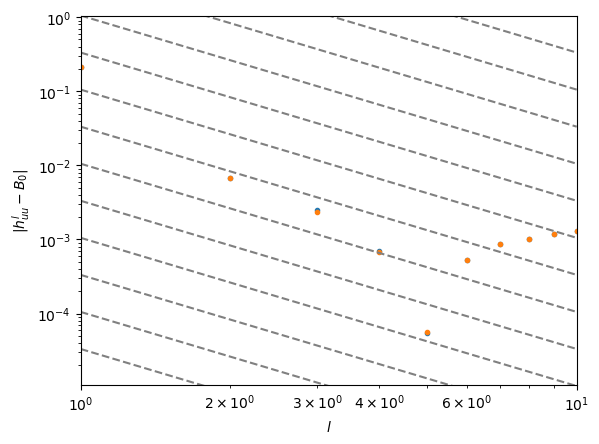

In [351]:
huuDataTest = huuGenTest2
lmax = huuDataTest[0].shape[0] - 1
lmodes = np.arange(1., lmax+1)
huuregB = orbit_average(huu_reg(geoEcc), geoEcc)
huul = orbit_average(huuDataTest[0], geoEcc, axis = 2)
datareg = huul - huuregB
ymin = np.min(np.abs(datareg[1:lmax + 1]))/5
ymax = 5*np.max(np.abs(datareg[1:lmax +1]))
plt.loglog(lmodes, np.abs(datareg[1:lmax + 1]), '.')
for i in range(20):
    plt.loglog(lmodes, ymax*10.**(2-0.5*i)*lmodes**(-2), '--', color='gray')
plt.ylim(ymin, ymax)
plt.xlim(1, lmax)
plt.xlabel("$l$")
plt.ylabel("$|h_{uu}^l - B_0|$")
plt.show()

# Hertz Tests

In [2]:
from pybhpt.geo import KerrGeodesic
from pybhpt.radial import RadialTeukolsky
from pybhpt.teuk import TeukolskyMode
from pybhpt.hertz import HertzMode
import numpy as np
import matplotlib.pyplot as plt

In [3]:
gauge = 'IRG'
geo = KerrGeodesic(0.0, 10., 0., 1.0, 2**2)
teuk = TeukolskyMode(-2, 2, 2, 0, 0, geo)
teuk.solve(geo)
teuk2 = TeukolskyMode(2, 2, 2, 0, 0, geo)
teuk2.solve(geo)
# print(teuk.teukolsky_amplitude('Up'), teuk.teukolsky_amplitude('In'))
# print(teuk2.teukolsky_amplitude('Up'), teuk2.teukolsky_amplitude('In'))
hertz = HertzMode(teuk, gauge)
hertz.solve()
hertz2 = HertzMode(teuk2, gauge)
hertz2.solve()
print(1.-hertz.amplitude('In')/hertz2.amplitude('In'))
print(1.-hertz.amplitude('Up')/hertz2.amplitude('Up'))

-1.0428790879943498e-15j
(6.661338147750939e-16+1.0042667994196633e-16j)


In [4]:
teuk.polarderivative2(0)

0.3153915652525201

In [5]:
teuk2.flipspinweight()
print(teuk2.homogeneousradialsolution("Up",0), teuk2.homogeneousradialsolution("In",0))

(7805.205087483132-3566.0391460544997j) (5754.689772338279+1787.9648163203212j)


In [6]:
print(teuk.homogeneousradialsolution("Up",0), teuk.homogeneousradialsolution("In",0))
print(teuk.homogeneousradialderivative("Up",0), teuk.homogeneousradialderivative("In",0))
print(teuk.homogeneousradialderivative2("Up",0), teuk.homogeneousradialderivative2("In",0))

(7805.205087483132-3566.0391460544997j) (5754.689772338277+1787.9648163203208j)
(-1154.096840225514-57.03881320255073j) (2478.4935684542634+1028.8022626558165j)
(180.47798538661954+47.12152909987104j) (759.9558699786119+468.93583025888967j)


In [7]:
print(teuk.amplitude('Up'), teuk.amplitude('In'))
print(teuk2.amplitude('Up'), teuk2.amplitude('In'))

(0.0011206407919254206-0.0003057608384581538j) (0.0014710247263310524+0.00038613052992468545j)
(0.0011206407919254215-0.0003057608384581538j) (0.0014710247263310528+0.0003861305299246838j)


In [8]:
Rt=RadialTeukolsky(-2, 2, 2, 0., teuk2.frequency, np.array([10.]))
Rt.solve('AUTO')

In [11]:
print(Rt.boundarypoint('Up'), Rt.boundarysolution('Up'), Rt.boundaryderivative('Up'))
print(Rt.radialpoint(0), Rt.radialsolution('Up', 0), Rt.radialderivative('Up', 0))

632.4555320336758 (-12438348524.679253-10363928701.344622j) (641189319.6786355-799521573.9794998j)
10.0 (7805.205087483132-3566.0391460544997j) (-1154.096840225514-57.03881320255073j)


# Mathematica to Python

In [ ]:
from sympy.parsing.mathematica import parse_mathematica
from sympy import var, Function, N
a, r, l, l1, m1, m, q, Omega = var('a r l l1 m1 m q Omega')
Hertz = Function("HertzFunc")
HertzDagger = Function("HertzDaggerFunc")
mu = Function("muCoupling")
CC = Function("C3Product")

## $h_{22}$

In [ ]:
expr="((q^4 - 5*r^4)*(HertzDaggerFunc[l, m, 0] + HertzFunc[l, m, 0])*muCoupling[l, 1]*muCoupling[l, 2])/40"
math_expr=parse_mathematica(expr)
print(math_expr)

(q**4 - 5*r**4)*(HertzDaggerFunc(l, m, 0) + HertzFunc(l, m, 0))*muCoupling(l, 1)*muCoupling(l, 2)/40


In [ ]:
expr="(Sqrt[Pi]*q*(143*Sqrt[30]*m1*Omega*q*((6*I)*r*(q^2 - 7*r^2) - m1*Omega*(q^4 - 21*r^4))*C3Product[l, m, 0, 2, 0, -2, l1, m1, 2]*HertzDaggerFunc[l1, m1, 0] - (286*I)*Sqrt[210]*q^2*(18*r + m1*Omega*(q^2*(I - m1*Omega*r) - 3*r^2*(-3*I + m1*Omega*r)))*C3Product[l, m, 0, 3, 0, -2, l1, m1, 2]*HertzDaggerFunc[l1, m1, 0] + 156*Sqrt[10]*m1*Omega*q^3*(-3*m1*Omega*q^2 + (11*I)*r)*C3Product[l, m, 0, 4, 0, -2, l1, m1, 2]*HertzDaggerFunc[l1, m1, 0] + 52*Sqrt[2310]*m1*Omega*q^4*(1 + I*m1*Omega*r)*C3Product[l, m, 0, 5, 0, -2, l1, m1, 2]*HertzDaggerFunc[l1, m1, 0] - 16*Sqrt[1365]*m1^2*Omega^2*q^5*C3Product[l, m, 0, 6, 0, -2, l1, m1, 2]*HertzDaggerFunc[l1, m1, 0] + 143*Sqrt[30]*m1*Omega*q*((6*I)*r*(q^2 - 7*r^2) - m1*Omega*(q^4 - 21*r^4))*C3Product[l, m, 0, l1, m1, -2, 2, 0, 2]*HertzFunc[l1, m1, 0] + (286*I)*Sqrt[210]*q^2*(18*r + m1*Omega*(q^2*(I - m1*Omega*r) - 3*r^2*(-3*I + m1*Omega*r)))*C3Product[l, m, 0, l1, m1, -2, 3, 0, 2]*HertzFunc[l1, m1, 0] + 156*Sqrt[10]*m1*Omega*q^3*(-3*m1*Omega*q^2 + (11*I)*r)*C3Product[l, m, 0, l1, m1, -2, 4, 0, 2]*HertzFunc[l1, m1, 0] + 52*Sqrt[2310]*m1*Omega*q^4*(-1 - I*m1*Omega*r)*C3Product[l, m, 0, l1, m1, -2, 5, 0, 2]*HertzFunc[l1, m1, 0] - 16*Sqrt[1365]*m1^2*Omega^2*q^5*C3Product[l, m, 0, l1, m1, -2, 6, 0, 2]*HertzFunc[l1, m1, 0] + 429*Sqrt[6]*((-3*I)*m1*Omega*q^4 - 7*q^2*r + 35*r^3*(1 + I*m1*Omega*r))*C3Product[l, m, 0, 1, 0, -1, l1, m1, 1]*HertzDaggerFunc[l1, m1, 0]*muCoupling[l1, 2] + (429*I)*Sqrt[30]*q*(7*r^2*(3 + (2*I)*m1*Omega*r) + q^2*(3 + (6*I)*m1*Omega*r))*C3Product[l, m, 0, 2, 0, -1, l1, m1, 1]*HertzDaggerFunc[l1, m1, 0]*muCoupling[l1, 2] + 572*Sqrt[21]*q^2*((-2*I)*m1*Omega*q^2 - 3*r)*C3Product[l, m, 0, 3, 0, -1, l1, m1, 1]*HertzDaggerFunc[l1, m1, 0]*muCoupling[l1, 2] + 1716*Sqrt[5]*q^3*(I - 2*m1*Omega*r)*C3Product[l, m, 0, 4, 0, -1, l1, m1, 1]*HertzDaggerFunc[l1, m1, 0]*muCoupling[l1, 2] - (104*I)*Sqrt[330]*m1*Omega*q^4*C3Product[l, m, 0, 5, 0, -1, l1, m1, 1]*HertzDaggerFunc[l1, m1, 0]*muCoupling[l1, 2] + 429*Sqrt[6]*(7*r*(q^2 - 5*r^2) + I*m1*Omega*(3*q^4 - 35*r^4))*C3Product[l, m, 0, l1, m1, -1, 1, 0, 1]*HertzFunc[l1, m1, 0]*muCoupling[l1, 2] + (429*I)*Sqrt[30]*q*(7*r^2*(3 + (2*I)*m1*Omega*r) + q^2*(3 + (6*I)*m1*Omega*r))*C3Product[l, m, 0, l1, m1, -1, 2, 0, 1]*HertzFunc[l1, m1, 0]*muCoupling[l1, 2] + 572*Sqrt[21]*q^2*((2*I)*m1*Omega*q^2 + 3*r)*C3Product[l, m, 0, l1, m1, -1, 3, 0, 1]*HertzFunc[l1, m1, 0]*muCoupling[l1, 2] + 1716*Sqrt[5]*q^3*(I - 2*m1*Omega*r)*C3Product[l, m, 0, l1, m1, -1, 4, 0, 1]*HertzFunc[l1, m1, 0]*muCoupling[l1, 2] + (104*I)*Sqrt[330]*m1*Omega*q^4*C3Product[l, m, 0, l1, m1, -1, 5, 0, 1]*HertzFunc[l1, m1, 0]*muCoupling[l1, 2] + (3003*I)*Sqrt[3]*r*(3*q^2 + 5*r^2)*C3Product[l, m, 0, 1, 0, 0, l1, m1, 0]*(-HertzDaggerFunc[l1, m1, 0] + HertzFunc[l1, m1, 0])*muCoupling[l1, 1]*muCoupling[l1, 2] + (2574*I)*Sqrt[7]*q^2*r*C3Product[l, m, 0, 3, 0, 0, l1, m1, 0]*(-HertzDaggerFunc[l1, m1, 0] + HertzFunc[l1, m1, 0])*muCoupling[l1, 1]*muCoupling[l1, 2] + 2574*Sqrt[5]*q^3*C3Product[l, m, 0, 2, 0, 0, l1, m1, 0]*(HertzDaggerFunc[l1, m1, 0] + HertzFunc[l1, m1, 0])*muCoupling[l1, 1]*muCoupling[l1, 2] + 1716*q^3*C3Product[l, m, 0, 4, 0, 0, l1, m1, 0]*(HertzDaggerFunc[l1, m1, 0] + HertzFunc[l1, m1, 0])*muCoupling[l1, 1]*muCoupling[l1, 2]))/90090"
math_expr=parse_mathematica(expr)
print(math_expr)

sqrt(pi)*q*(-16*sqrt(1365)*Omega**2*m1**2*q**5*C3Product(l, m, 0, 6, 0, -2, l1, m1, 2)*HertzDaggerFunc(l1, m1, 0) - 16*sqrt(1365)*Omega**2*m1**2*q**5*C3Product(l, m, 0, l1, m1, -2, 6, 0, 2)*HertzFunc(l1, m1, 0) + 52*sqrt(2310)*Omega*m1*q**4*(-I*Omega*m1*r - 1)*C3Product(l, m, 0, l1, m1, -2, 5, 0, 2)*HertzFunc(l1, m1, 0) + 52*sqrt(2310)*Omega*m1*q**4*(I*Omega*m1*r + 1)*C3Product(l, m, 0, 5, 0, -2, l1, m1, 2)*HertzDaggerFunc(l1, m1, 0) - 104*sqrt(330)*I*Omega*m1*q**4*C3Product(l, m, 0, 5, 0, -1, l1, m1, 1)*HertzDaggerFunc(l1, m1, 0)*muCoupling(l1, 2) + 104*sqrt(330)*I*Omega*m1*q**4*C3Product(l, m, 0, l1, m1, -1, 5, 0, 1)*HertzFunc(l1, m1, 0)*muCoupling(l1, 2) + 156*sqrt(10)*Omega*m1*q**3*(-3*Omega*m1*q**2 + 11*I*r)*C3Product(l, m, 0, 4, 0, -2, l1, m1, 2)*HertzDaggerFunc(l1, m1, 0) + 156*sqrt(10)*Omega*m1*q**3*(-3*Omega*m1*q**2 + 11*I*r)*C3Product(l, m, 0, l1, m1, -2, 4, 0, 2)*HertzFunc(l1, m1, 0) + 143*sqrt(30)*Omega*m1*q*(-Omega*m1*(q**4 - 21*r**4) + 6*I*r*(q**2 - 7*r**2))*C3Product(l, 

## $h_{23}$

In [ ]:
expr="(((-6*r*(q^2 + (-2 + r)*r) - I*m*Omega*(q^2 + r^2)*(q^2 + 3*r^2))*HertzDaggerFunc[l, m, 0] + (q^2 + (-2 + r)*r)*(q^2 + 3*r^2)*HertzDaggerFunc[l, m, 1])*muCoupling[l, 2])/(12*Sqrt[2]*(q^2 + (-2 + r)*r))"
math_expr=parse_mathematica(expr)
print(math_expr)

sqrt(2)*((q**2 + 3*r**2)*(q**2 + r*(r - 2))*HertzDaggerFunc(l, m, 1) + (-I*Omega*m*(q**2 + r**2)*(q**2 + 3*r**2) - 6*r*(q**2 + r*(r - 2)))*HertzDaggerFunc(l, m, 0))*muCoupling(l, 2)/(24*(q**2 + r*(r - 2)))


In [ ]:
expr="(Sqrt[Pi]*q*(7*Sqrt[3]*m1*Omega*C3Product[l, m, 1, 1, 0, -1, l1, m1, 2]*(-(m1*Omega*(q^2 + r^2)*(q^2 + 5*r^2)*HertzDaggerFunc[l1, m1, 0]) - I*(q^2 + (-2 + r)*r)*(-10*r*HertzDaggerFunc[l1, m1, 0] + (q^2 + 5*r^2)*HertzDaggerFunc[l1, m1, 1])) + q*(m1*Omega*(q^2 + r^2)*HertzDaggerFunc[l1, m1, 0] + I*(q^2 + (-2 + r)*r)*HertzDaggerFunc[l1, m1, 1])*(14*Sqrt[15]*C3Product[l, m, 1, 2, 0, -1, l1, m1, 2] - 2*Sqrt[42]*m1*Omega*q*C3Product[l, m, 1, 3, 0, -1, l1, m1, 2] - (7*I)*Sqrt[10]*C3Product[l, m, 1, 2, 0, 0, l1, m1, 1]*muCoupling[l1, 2])))/(210*(q^2 + (-2 + r)*r))"
math_expr=parse_mathematica(expr)
print(math_expr)

sqrt(pi)*q*(7*sqrt(3)*Omega*m1*(-Omega*m1*(q**2 + r**2)*(q**2 + 5*r**2)*HertzDaggerFunc(l1, m1, 0) - I*(q**2 + r*(r - 2))*(-10*r*HertzDaggerFunc(l1, m1, 0) + (q**2 + 5*r**2)*HertzDaggerFunc(l1, m1, 1)))*C3Product(l, m, 1, 1, 0, -1, l1, m1, 2) + q*(Omega*m1*(q**2 + r**2)*HertzDaggerFunc(l1, m1, 0) + I*(q**2 + r*(r - 2))*HertzDaggerFunc(l1, m1, 1))*(-2*sqrt(42)*Omega*m1*q*C3Product(l, m, 1, 3, 0, -1, l1, m1, 2) + 14*sqrt(15)*C3Product(l, m, 1, 2, 0, -1, l1, m1, 2) - 7*sqrt(10)*I*C3Product(l, m, 1, 2, 0, 0, l1, m1, 1)*muCoupling(l1, 2)))/(210*q**2 + 210*r*(r - 2))


## $h_{24}$

In [ ]:
expr="(((6*r*(q^2 + (-2 + r)*r) + I*m*Omega*(q^2 + r^2)*(q^2 + 3*r^2))*HertzFunc[l, m, 0] - (q^2 + (-2 + r)*r)*(q^2 + 3*r^2)*HertzFunc[l, m, 1])*muCoupling[l, 2])/(12*Sqrt[2]*(q^2 + (-2 + r)*r))"
math_expr=parse_mathematica(expr)
print(math_expr)

sqrt(2)*(-(q**2 + 3*r**2)*(q**2 + r*(r - 2))*HertzFunc(l, m, 1) + (I*Omega*m*(q**2 + r**2)*(q**2 + 3*r**2) + 6*r*(q**2 + r*(r - 2)))*HertzFunc(l, m, 0))*muCoupling(l, 2)/(24*(q**2 + r*(r - 2)))


In [ ]:
expr="(Sqrt[Pi]*q*(7*Sqrt[3]*m1*Omega*C3Product[l, m, -1, l1, m1, -2, 1, 0, 1]*(-(m1*Omega*(q^2 + r^2)*(q^2 + 5*r^2)*HertzFunc[l1, m1, 0]) - I*(q^2 + (-2 + r)*r)*(-10*r*HertzFunc[l1, m1, 0] + (q^2 + 5*r^2)*HertzFunc[l1, m1, 1])) - q*(m1*Omega*(q^2 + r^2)*HertzFunc[l1, m1, 0] + I*(q^2 + (-2 + r)*r)*HertzFunc[l1, m1, 1])*(14*Sqrt[15]*C3Product[l, m, -1, l1, m1, -2, 2, 0, 1] + 2*Sqrt[42]*m1*Omega*q*C3Product[l, m, -1, l1, m1, -2, 3, 0, 1] - (7*I)*Sqrt[10]*C3Product[l, m, -1, l1, m1, -1, 2, 0, 0]*muCoupling[l1, 2])))/(210*(q^2 + (-2 + r)*r))"
math_expr=parse_mathematica(expr)
print(math_expr)

sqrt(pi)*q*(7*sqrt(3)*Omega*m1*(-Omega*m1*(q**2 + r**2)*(q**2 + 5*r**2)*HertzFunc(l1, m1, 0) - I*(q**2 + r*(r - 2))*(-10*r*HertzFunc(l1, m1, 0) + (q**2 + 5*r**2)*HertzFunc(l1, m1, 1)))*C3Product(l, m, -1, l1, m1, -2, 1, 0, 1) - q*(Omega*m1*(q**2 + r**2)*HertzFunc(l1, m1, 0) + I*(q**2 + r*(r - 2))*HertzFunc(l1, m1, 1))*(2*sqrt(42)*Omega*m1*q*C3Product(l, m, -1, l1, m1, -2, 3, 0, 1) + 14*sqrt(15)*C3Product(l, m, -1, l1, m1, -2, 2, 0, 1) - 7*sqrt(10)*I*C3Product(l, m, -1, l1, m1, -1, 2, 0, 0)*muCoupling(l1, 2)))/(210*q**2 + 210*r*(r - 2))


## $h_{33}$

In [ ]:
expr="(-(m*Omega*(q^4*(-2*I + m*Omega*r) + r^3*(2*I + r*(-2*I + m*Omega*r)) + 2*q^2*r*(3*I + r*(-2*I + m*Omega*r)))*HertzDaggerFunc[l, m, 0]) + (q^2 + (-2 + r)*r)*((4*r - (2*I)*(-I + m*Omega*r)*(q^2 + r^2))*HertzDaggerFunc[l, m, 1] + r*(q^2 + (-2 + r)*r)*HertzDaggerFunc[l, m, 2]))/(4*(q^2 + (-2 + r)*r)^2)"
math_expr=parse_mathematica(expr)
print(math_expr)

(-Omega*m*(q**4*(Omega*m*r - 2*I) + 2*q**2*r*(r*(Omega*m*r - 2*I) + 3*I) + r**3*(r*(Omega*m*r - 2*I) + 2*I))*HertzDaggerFunc(l, m, 0) + (q**2 + r*(r - 2))*(r*(q**2 + r*(r - 2))*HertzDaggerFunc(l, m, 2) + (4*r - 2*I*(q**2 + r**2)*(Omega*m*r - I))*HertzDaggerFunc(l, m, 1)))/(4*(q**2 + r*(r - 2))**2)


In [ ]:
expr="((-1/2*I)*Sqrt[Pi/3]*q*C3Product[l, m, 2, 1, 0, 0, l1, m1, 2]*((2*I)*m1*Omega*(q - r)*(q + r)*HertzDaggerFunc[l1, m1, 0] + m1^2*Omega^2*(q^2 + r^2)^2*HertzDaggerFunc[l1, m1, 0] + (q^2 + (-2 + r)*r)*((2*I)*m1*Omega*(q^2 + r^2)*HertzDaggerFunc[l1, m1, 1] - (q^2 + (-2 + r)*r)*HertzDaggerFunc[l1, m1, 2])))/(q^2 + (-2 + r)*r)^2"
math_expr=parse_mathematica(expr)
print(math_expr)

-sqrt(3)*I*sqrt(pi)*q*(Omega**2*m1**2*(q**2 + r**2)**2*HertzDaggerFunc(l1, m1, 0) + 2*I*Omega*m1*(q - r)*(q + r)*HertzDaggerFunc(l1, m1, 0) + (q**2 + r*(r - 2))*(2*I*Omega*m1*(q**2 + r**2)*HertzDaggerFunc(l1, m1, 1) - (q**2 + r*(r - 2))*HertzDaggerFunc(l1, m1, 2)))*C3Product(l, m, 2, 1, 0, 0, l1, m1, 2)/(6*(q**2 + r*(r - 2))**2)


## $h_{44}$

In [ ]:
expr="(-(m*Omega*(q^4*(-2*I + m*Omega*r) + r^3*(2*I + r*(-2*I + m*Omega*r)) + 2*q^2*r*(3*I + r*(-2*I + m*Omega*r)))*HertzFunc[l, m, 0]) + (q^2 + (-2 + r)*r)*((4*r - (2*I)*(-I + m*Omega*r)*(q^2 + r^2))*HertzFunc[l, m, 1] + r*(q^2 + (-2 + r)*r)*HertzFunc[l, m, 2]))/(4*(q^2 + (-2 + r)*r)^2)"
math_expr=parse_mathematica(expr)
print(math_expr)

(-Omega*m*(q**4*(Omega*m*r - 2*I) + 2*q**2*r*(r*(Omega*m*r - 2*I) + 3*I) + r**3*(r*(Omega*m*r - 2*I) + 2*I))*HertzFunc(l, m, 0) + (q**2 + r*(r - 2))*(r*(q**2 + r*(r - 2))*HertzFunc(l, m, 2) + (4*r - 2*I*(q**2 + r**2)*(Omega*m*r - I))*HertzFunc(l, m, 1)))/(4*(q**2 + r*(r - 2))**2)


In [ ]:
expr="((I/2)*Sqrt[Pi/3]*q*C3Product[l, m, -2, l1, m1, -2, 1, 0, 0]*((2*I)*m1*Omega*(q - r)*(q + r)*HertzFunc[l1, m1, 0] + m1^2*Omega^2*(q^2 + r^2)^2*HertzFunc[l1, m1, 0] + (q^2 + (-2 + r)*r)*((2*I)*m1*Omega*(q^2 + r^2)*HertzFunc[l1, m1, 1] - (q^2 + (-2 + r)*r)*HertzFunc[l1, m1, 2])))/(q^2 + (-2 + r)*r)^2"
math_expr=parse_mathematica(expr)
print(math_expr)

sqrt(3)*I*sqrt(pi)*q*(Omega**2*m1**2*(q**2 + r**2)**2*HertzFunc(l1, m1, 0) + 2*I*Omega*m1*(q - r)*(q + r)*HertzFunc(l1, m1, 0) + (q**2 + r*(r - 2))*(2*I*Omega*m1*(q**2 + r**2)*HertzFunc(l1, m1, 1) - (q**2 + r*(r - 2))*HertzFunc(l1, m1, 2)))*C3Product(l, m, -2, l1, m1, -2, 1, 0, 0)/(6*(q**2 + r*(r - 2))**2)
